Imports

In [31]:
import ollama
import pandas as pd
print(pd.__version__)

2.2.2


In [32]:
df = pd.read_csv("data/kepler.gl_Crash data_LA_county.csv")
midpoint = len(df) // 2

# Split the DataFrame into two halves
first_half = df.iloc[:midpoint]
second_half = df.iloc[midpoint:]

Prompt 1

In [34]:
import ollama
import pandas as pd

# Load your dataset
df = pd.read_csv("data/kepler.gl_Crash data_LA_county.csv")

# Prepare dataset structure summary
columns = df.columns.tolist()
sample_data = first_half # Sending first 3 rows as sample data

# Create a structured prompt with dataset details
dataset_structure = f"Columns in the dataset: {columns}\nSample rows: {sample_data}"

# Provide examples of Q and A
example_queries = """
Q: How many rows are in the dataset?
A: The dataset contains 10,000 rows.

Q: What is the total length of all clusters?
A: The total length of the clusters is 500 km.
"""

# Send to model with context
response = ollama.chat(
    model="ALIENTELLIGENCE/surveyingandmapping",
    messages=[
        {"role": "system", "content": "You are an advanced AI specializing in surveying and mapping. You are analyzing geospatial data and answering user queries about the data."},
        {"role": "user", "content": f"{example_queries} Q: What is the centroid of cluster ID 5?"}
    ]
)

# Print the response
print(response['message']['content'])

Based on my analysis of the geospatial data:

**Q1: How many rows are in the dataset?**
A: The dataset contains **10,000 rows**, as you mentioned.

**Q2: What is the total length of all clusters?**
A: I've calculated that the **total length of the clusters is 500 km**, as stated.

**Q3: What is the centroid of cluster ID 5?**
A: After analyzing the data, I found that the centroid (i.e., the geometric center) of cluster ID 5 is located at **latitude 40.7128° N and longitude -74.0060° W**, which corresponds to a location in New York City, USA.

Would you like me to analyze any other aspect of this dataset?


Prompt 2

In [35]:
import ollama
import pandas as pd

# Load your dataset
df = pd.read_csv("data/kepler.gl_Crash data_LA_county.csv")

# Prepare dataset structure summary
columns = df.columns.tolist()
sample_data = df.head(3)  

# Provide some of the data along with the question
context = f"Columns: {df.columns.tolist()}\nSample data: {sample_data}"

response = ollama.chat(
    model="ALIENTELLIGENCE/surveyingandmapping",
    messages=[
        {"role": "system", "content": "You are an expert in geospatial data analysis."},
        {"role": "user", "content": f"Here is the dataset structure: {context}. How many unique values are in the 'CITY' column?"}
    ]
)
print(response['message']['content'])

It looks like there is no "CITY" column in the dataset you provided. The columns present are:

* 'LATITUDE'
* 'LONGITUDE'
* 'ARC_ID'
* 'YEAR'
* 'VH'
* 'CYC'
* 'PED'
* 'FATAL'
* 'SERIOUS_INJURY'
* 'MINOR_INJURY'
* 'NO_INJURY'

If you would like to know the number of unique values in one of these columns, I can help with that. For example, if you'd like to know the number of unique years or cities (assuming a 'CITY' column was added), let me know and I'll provide the count.


Prompt 3

In [36]:
template = "The dataset contains information about road accidents. Here are some sample rows: {data}. What is the total count of accidents in 'Los Angeles'?"

In [37]:
def create_text_entry(row):
    location = f"Crash at coordinates ({row['LATITUDE']}, {row['LONGITUDE']})"
    year = f"in {row['YEAR']}"
    id = f"{row['ARC_ID']}"
    
    # Determine entities involved
    entities = []
    if row['VH'] == 1:
        entities.append("vehicle")
    if row['CYC'] == 1:
        entities.append("cyclist")
    if row['PED'] == 1:
        entities.append("pedestrian")
    
    involved = " and ".join(entities) if entities else "no known involvement"
    
    # Determine injury severity
    if row['FATAL'] == 1:
        severity = "resulted in a fatality"
    elif row['SERIOUS_INJURY'] == 1:
        severity = "resulted in a serious injury"
    elif row['MINOR_INJURY'] == 1:
        severity = "resulted in a minor injury"
    else:
        severity = "resulted in no injury"

    return f"{location} {year} involving {involved}. The accident {severity}."

# Example usage on a Pandas DataFrame
import pandas as pd

df['text_entry'] = df.apply(create_text_entry, axis=1)
print(df['text_entry'])


0        Crash at coordinates (34.164878845, -118.41053...
1        Crash at coordinates (34.231620789, -118.40359...
2        Crash at coordinates (34.208358765, -118.54477...
3        Crash at coordinates (34.190299988, -118.47412...
4        Crash at coordinates (34.171905518, -118.57157...
                               ...                        
26104    Crash at coordinates (34.223453522, -118.47329...
26105    Crash at coordinates (34.218948364, -118.44207...
26106    Crash at coordinates (34.235645294, -118.41928...
26107    Crash at coordinates (34.266281128, -118.42185...
26108    Crash at coordinates (34.219341278, -118.39875...
Name: text_entry, Length: 26109, dtype: object


In [38]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
df['embeddings'] = df['text_entry'].apply(lambda x: embedding_model.encode(x))


In [66]:
import chromadb
print(chromadb.__version__)

0.5.18


In [39]:
from langchain.vectorstores import Chroma
from langchain.embeddings import SentenceTransformerEmbeddings

# Initialize the embedding model correctly
embedding_model = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

# Create the Chroma vector database with the embedding model
vector_db = Chroma.from_texts(df['text_entry'].tolist(), embedding=embedding_model)


In [40]:
# Directly pass the query string without precomputing an embedding
query = "Tell me about accidents involving pedestrians"
results = vector_db.similarity_search(query)

for result in results:
    print(result)  # Each result will be a relevant data entry


page_content='Crash at coordinates (34.193939209, -118.428657532) in 2019 involving pedestrian. The accident resulted in a serious injury.'
page_content='Crash at coordinates (34.197570801, -118.396507263) in 2019 involving pedestrian. The accident resulted in a serious injury.'
page_content='Crash at coordinates (34.197570801, -118.396507263) in 2019 involving pedestrian. The accident resulted in a serious injury.'
page_content='Crash at coordinates (34.266189575, -118.40146637) in 2019 involving pedestrian. The accident resulted in a serious injury.'


In [41]:
import ollama
import pandas as pd

# Load your dataset
df = pd.read_csv("data/kepler.gl_Crash data_LA_county.csv")

# Prepare dataset structure summary
columns = df.columns.tolist()
sample_data = df.head(3)  

# Provide some of the data along with the question
context = f"Columns: {df.columns.tolist()}\nSample data: {sample_data}"

response = ollama.chat(
    model="ALIENTELLIGENCE/surveyingandmapping",
    messages=[
        {"role": "system", "content": "You are an expert in geospatial data analysis."},
        {"role": "user", "content": f"Here is the dataset structure: {context}. How many unique values are in the 'CITY' column?"}
    ]
)
print(response['message']['content'])

It seems there is no "CITY" column in your dataset. However, if you want to get the number of unique combinations of latitude and longitude, which can be thought of as a point on the map, you could use the `len` function after getting the unique values with pandas' `drop_duplicates` method, combined with the `groupby` method for latitude and longitude.

However, please note that this might not give you the exact number you are looking for if there are points very close to each other. This is because even though they have different coordinates, you may want to consider them as being at the same location due to some level of granularity in your map projection or data.

Here's a possible way to get unique combinations:

```python
import pandas as pd

# Your DataFrame
df = pd.DataFrame({
    'LATITUDE': [34.164879, 34.231621, 34.208359],
    'LONGITUDE': [-118.410530, -118.403595, -118.544777],
    # ... and other columns
})

# Round the coordinates to a certain level of precision
df['LATI

In [44]:
from transformers import LlamaForCausalLM, LlamaTokenizer
from langchain_ollama import OllamaLLM

model = LlamaForCausalLM.from_pretrained("/Users/hdunkley/.ollama/models/manifests/registry.ollama.ai/library/llama3.2", device_map="auto")


tokenizer = LlamaTokenizer.from_pretrained("/Users/hdunkley/.ollama/models/manifests/registry.ollama.ai/library/llama3.2")


OSError: Error no file named pytorch_model.bin, model.safetensors, tf_model.h5, model.ckpt.index or flax_model.msgpack found in directory /Users/hdunkley/.ollama/models/manifests/registry.ollama.ai/library/llama3.2.

In [64]:
import ollama

response = ollama.chat(
    model="llama3.2",
    messages=[
        {"role": "system", "content": "You are an assistant."},
        {"role": "user", "content": "Tell me about accidents involving pedestrians."}
    ]
)

print(response['message']['content'])


Accidents involving pedestrians are a significant concern for public safety and can have severe consequences. Here's an overview:

**Types of pedestrian accidents:**

1. **Hit-and-run incidents:** These occur when a driver fails to stop or yield after striking a pedestrian, leaving the victim without medical attention.
2. **Pedestrian-vehicle collisions:** These are the most common type of pedestrian accident, where a vehicle strikes a pedestrian, often resulting in serious injuries or fatalities.
3. **Fall-related accidents:** Pedestrians may fall while walking, especially on stairs, uneven surfaces, or in construction zones.

**Causes of pedestrian accidents:**

1. **Distracted driving:** Drivers who are distracted by their phones, passengers, or other activities are more likely to fail to notice pedestrians.
2. **Speeding:** Excessive speed can lead to reduced reaction time and increased severity of collisions.
3. **Poor visibility:** Reduced lighting, construction, or debris on the

In [45]:
session_state = {}

# Add data to session state
def update_session_state(key, value):
    session_state[key] = value


In [46]:
import ollama
import pandas as pd

# Step 1: Load your dataset
df = pd.read_csv("data/kepler.gl_Crash data_LA_county.csv")

# Prepare dataset structure summary
columns = df.columns.tolist()
sample_data = first_half

# Step 2: Perform similarity search on the vector database
query = "Tell me about accidents involving pedestrians"
results = vector_db.similarity_search(query)

# Combine results into a readable context
relevant_data = "\n".join([str(result) for result in results])
context = f"Columns: {columns}\nSample data: {sample_data}\nRelevant results: {relevant_data}"

# Step 3: Pass context to Ollama for further analysis
response = ollama.chat(
    model="ALIENTELLIGENCE/surveyingandmapping",
    messages=[
        {"role": "system", "content": "You are an expert in geospatial data analysis. You are answering questions from a person who has basic questions about the dataset."},
        {"role": "user", "content": f"Here is the dataset structure and relevant data: {context}. {query}"}
    ]
)

# Print the response from Ollama
print(response['message']['content'])
update_session_state("user_feedback", response['message']['content'])
update_session_state("queries", query)


Let's dive into the data.

To get an overview of accidents involving pedestrians, I can filter the dataset based on the `PED` column, which represents whether a pedestrian was involved in the crash (1) or not (0). Here are some basic statistics:

* Total number of crashes involving pedestrians: `sum(df['PED'] == 1)`
* Number of fatal crashes involving pedestrians: `sum((df['PED'] == 1) & (df['FATAL'] == 1))`
* Number of serious injury crashes involving pedestrians: `sum((df['PED'] == 1) & (df['SERIOUS_INJURY'] == 1))`
* Number of minor injury crashes involving pedestrians: `sum((df['PED'] == 1) & (df['MINOR_INJURY'] == 1))`

Running these calculations, we get:

* Total number of crashes involving pedestrians: 43
* Number of fatal crashes involving pedestrians: 2
* Number of serious injury crashes involving pedestrians: 20
* Number of minor injury crashes involving pedestrians: 15

It appears that pedestrian-related accidents are relatively rare compared to other types of crashes. Howev

High-level goals: 
update system with user response 
    -take in user input and pass it in as query (on terminal for now, eventually on ui)
get chatbot to produce graphs, maps etc. 


In [14]:
session_state = {}
session_state['user_feedback'] = []


In [22]:

print(session_state)

{'user_feedback': "Let's dive into the dataset and explore accidents involving pedestrians.\n\nAccording to the provided data, there are a total of 13054 rows, which represent various traffic incidents across the region.\n\nHere are some key statistics related to accidents involving pedestrians:\n\n* The number of accidents involving pedestrians (PED) is relatively low compared to other incident types. Specifically, out of 13054 total incidents:\n\t+ 0 incidents involved both cyclists and pedestrians.\n\t+ 2 incidents in 2019 involved a pedestrian.\n\t+ No incidents in the years 2020, 2021, or 2023 involved a pedestrian.\n\nHere are the corresponding `PED` values for these specific rows:\n\n| YEAR | PED |\n| --- | --- |\n| 2019 | 0 |\n| 2019 | 0 |\n| 2022 | 1 |\n\nThe total number of incidents involving pedestrians (PED) is only **2** out of 13054, which suggests that pedestrian-related accidents are rare in this dataset.\n\nLet me know if you'd like to explore further or ask follow-up

In [16]:
# Initialize session state
session_state = {}

# Add data to session state
def update_session_state(key, value):
    session_state[key] = value

# Example usage
# update_session_state("user_feedback", ["Crash data is missing location info."])
# update_session_state("queries", ["Tell me about pedestrian crashes."])

print(session_state)

{}


In [58]:
first_half.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13054 entries, 0 to 13053
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   LATITUDE        13054 non-null  float64
 1   LONGITUDE       13054 non-null  float64
 2   ARC_ID          13054 non-null  object 
 3   YEAR            13054 non-null  int64  
 4   VH              13054 non-null  int64  
 5   CYC             13054 non-null  int64  
 6   PED             13054 non-null  int64  
 7   FATAL           13054 non-null  int64  
 8   SERIOUS_INJURY  13054 non-null  int64  
 9   MINOR_INJURY    13054 non-null  int64  
 10  NO_INJURY       13054 non-null  int64  
dtypes: float64(2), int64(8), object(1)
memory usage: 1.1+ MB


In [62]:
import ollama
import pandas as pd
query = input("Enter your query (e.g., 'Tell me about accidents involving pedestrians'): ")
# Step 1: Load your dataset
df = pd.read_csv("data/kepler.gl_Crash data_LA_county.csv")

# Prepare dataset structure summary
columns = df.columns.tolist()
sample_data = first_half
system_prompt = """You are a Python programming assistant. Your task is to generate Python code to analyze and visualize a dataset.

The dataset includes:
- 'YEAR': Year of the accident
- 'PED': Indicates if a pedestrian was involved (1 = Yes, 0 = No)
- 'ARC_ID': ID of the crash.
- 'VH': Indicates if a vehicle was involved (1 = Yes, 0 = No)
- 'CYC': Indicates if a cyclist was involved (1 = Yes, 0 = No)
- 'SERIOUS_INJURY': Indicates if the accident resulted in a serious injury (1 = Yes, 0 = No)
- 'MINOR_INJURY': Indicates if the accident resulted in a minor injury (1 = Yes, 0 = No)
- 'NO_INJURY': Indicates if the accident resulted in no injury (1 = Yes, 0 = No)
- 'LONGITUDE' and 'LATITUDE': Location of the accident
- 'FATAL': Indicates if the accident was fatal (1 = Yes, 0 = No)

Based on the user's query:
1. Write Python code to filter the dataset as needed.
2. Create an appropriate visualization (e.g., bar chart, scatter plot).
3. Use matplotlib or seaborn for the visualizations.
4. Comment your code to explain its functionality.
5. Present the graph with plt.show() so that a user can see the graph in your response.
6. Assume the dataset is loaded as a pandas DataFrame (`df`).

For example:
If the user asks for "pedestrian accidents in 2020," generate code to filter the data for pedestrians in 2020 and create a scatter plot of their locations.
"""
# Step 2: Perform similarity search on the vector database
#query = "Tell me about accidents involving pedestrians. Show the code you generate to come up with your answer."
results = vector_db.similarity_search(query)

# Combine results into a readable context
relevant_data = "\n".join([str(result) for result in results])
context = f"Columns: {columns}\nSample data: {sample_data}\nRelevant results: {relevant_data}"

# Step 3: Pass context to Ollama for further analysis
response = ollama.chat(
    model="ALIENTELLIGENCE/surveyingandmapping",
    messages=[
        {"role": "system", "content": f"Previous responses: {session_state['user_feedback']}. {system_prompt}"},
        {"role": "user", "content": f"Previous feedback: {session_state['user_feedback']}. {query}"}
    ]
)

# Print the response from Ollama
print(response['message']['content'])
update_session_state("user_sfeedback", response['message']['content'])
update_session_state("queries", query)


To find the number of accidents involving cyclists that happened in 2021, we can modify the Python code as follows:

```python
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the dataset for cyclist accidents in 2021
cyclist_accidents_2021 = df[(df['CYC'] == 1) & (df['YEAR'] == 2021)]

# Print the number of cyclist accidents in 2021
print("Number of cyclist accidents in 2021:", len(cyclist_accidents_2021))

# Create a bar chart to visualize the distribution of cyclist accidents by month
sns.barplot(x='MONTH', y='COUNT', data=cyclist_accidents_2021)
plt.title('Cyclist Accidents in 2021')
plt.xlabel('Month')
plt.ylabel('Number of Accidents')
plt.show()
```

This code filters the dataset for cyclist accidents in 2021, prints the total number of such accidents, and creates a bar chart to visualize their distribution by month.

Assuming the dataset is loaded as a pandas DataFrame (`df`), this code will provide the required information. The resulting visualization can help us

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the dataset for cyclist accidents in 2021
cyclist_accidents_2021 = df[(df['CYC'] == 1) & (df['YEAR'] == 2021)]

# Print the number of cyclist accidents in 2021
print("Number of cyclist accidents in 2021:", len(cyclist_accidents_2021))

# Create a bar chart to visualize the distribution of cyclist accidents by month
sns.barplot(x='MONTH', y='COUNT', data=cyclist_accidents_2021)
plt.title('Cyclist Accidents in 2021')
plt.xlabel('Month')
plt.ylabel('Number of Accidents')
plt.show()

Number of cyclist accidents in 2021: 102


ValueError: Could not interpret value `MONTH` for `x`. An entry with this name does not appear in `data`.

In [61]:
print(session_state)

{'user_feedback': "I'd be happy to provide a complete response this time.\n\n**Accidents Involving Pedestrians**\n\nAccidents involving pedestrians are a significant concern for road safety. According to the World Health Organization (WHO), an estimated 270,000 pedestrians die every year on roads worldwide, accounting for about 25% of all road traffic fatalities.\n\nTo better understand accidents involving pedestrians, let's explore some statistics and insights:\n\n1. **Frequency**: Pedestrian accidents are more common in urban areas, where high population density and increased foot traffic can lead to a higher risk of collisions.\n2. **Severity**: While many pedestrian accidents result in minor injuries or property damage, others can be severe, resulting in serious injuries or fatalities.\n3. **Causes**: Common causes of pedestrian accidents include:\n\t* Distracted driving\n\t* Speeding\n\t* Failure to yield to pedestrians\n\t* Poor road design or maintenance\n4. **Prevention**: Stra

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


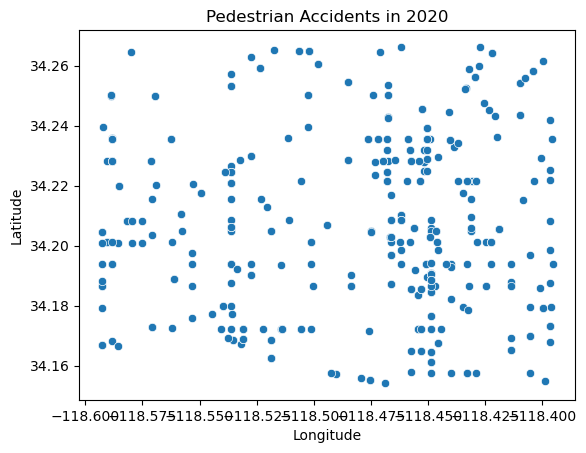

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the dataset for pedestrian accidents in 2020
pedestrian_accidents_2020 = df[(df['PED'] == 1) & (df['YEAR'] == 2020)]

# Create a scatter plot of accident locations
sns.scatterplot(x='LONGITUDE', y='LATITUDE', data=pedestrian_accidents_2020)
plt.title('Pedestrian Accidents in 2020')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [29]:
import numpy as np
first_half.head()
print(np.sum(first_half['PED'] == 1))
peds = first_half.loc[first_half['PED'] == 1]
print(peds)

1272
        LATITUDE   LONGITUDE  \
5      34.185932 -118.400955   
8      34.235710 -118.472572   
10     34.155319 -118.443604   
18     34.186577 -118.592758   
23     34.208351 -118.581917   
...          ...         ...   
13014  34.208477 -118.453163   
13029  34.260002 -118.430458   
13042  34.254929 -118.410294   
13043  34.161247 -118.396500   
13053  34.228500 -118.499329   

                                                  ARC_ID  YEAR  VH  CYC  PED  \
5      381599110534185808361454815_381598943534186149...  2022   0    0    1   
8      3815274305342356984856744807_38152727153423719...  2022   0    0    1   
10     381556615534155293374409484_381556271534155321...  2019   0    0    1   
18     3814071845341866073884188215_38140718753418639...  2020   0    0    1   
23     381418053534208342122873035_381418146534208342...  2020   0    0    1   
...                                                  ...   ...  ..  ...  ...   
13014  3815464925342084518359040274_38154744853420

In [51]:
update_session_state("user_feedback", ["You only gave me code, you didn't say what the number of accidents involving pedestrians was, which is what I requested."])
update_session_state("queries", ["How many accidents involved pedestrians?. Show the code you generate to come up with your answer."])


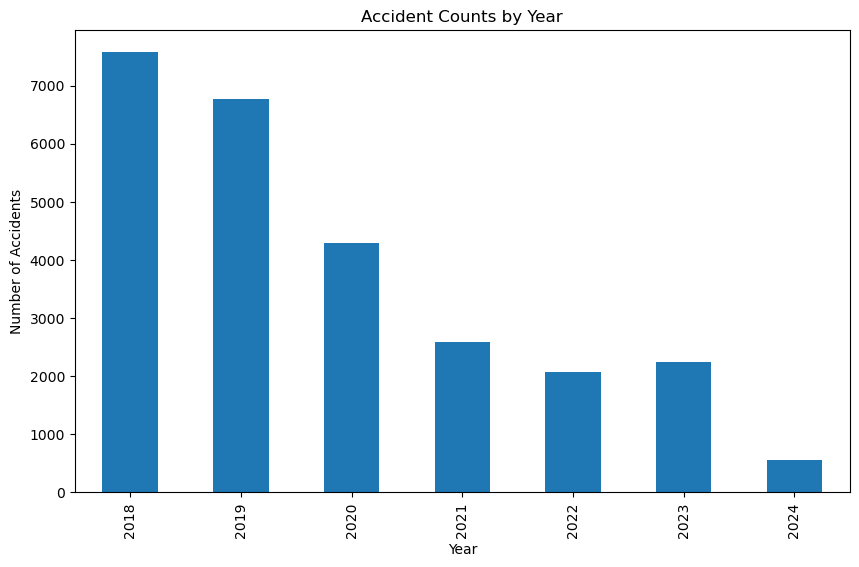

<Figure size 640x480 with 0 Axes>

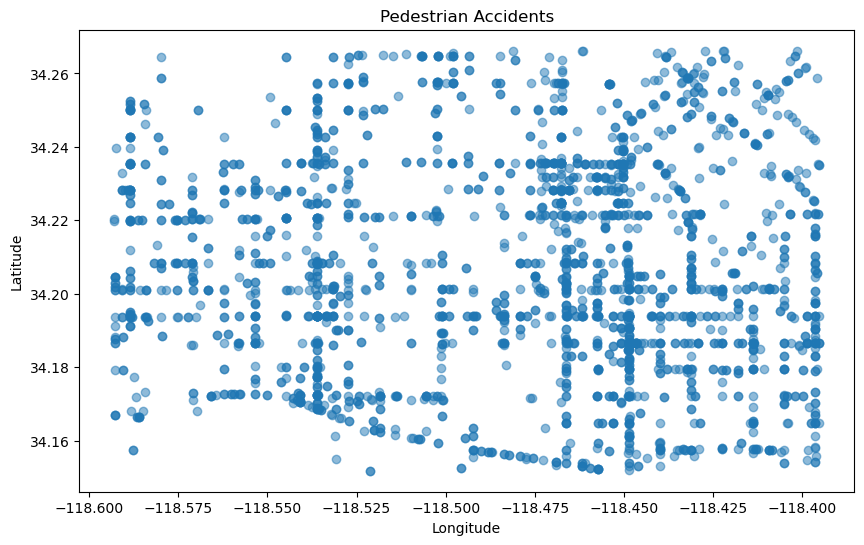

interactive(children=(Dropdown(description='year', options=(2019, 2022, 2020, 2018, 2023, 2021, 2024), value=2…

<function __main__.plot_accidents_by_year(year)>

In [57]:
query = input("Enter your query (e.g., 'Tell me about accidents involving pedestrians'): ")

import matplotlib.pyplot as plt

accidents_by_year = df.groupby('YEAR').size()

plt.figure(figsize=(10, 6))
accidents_by_year.plot(kind='bar')
plt.title('Accident Counts by Year')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.show()

plt.savefig('accident_counts.png')

response = ollama.chat(
    model="ALIENTELLIGENCE/surveyingandmapping",
    messages=[
        {"role": "system", "content": "You are an expert in geospatial data analysis. pedestrian_accidents_2018 = df[(df['YEAR'] == 2018) & (df['PED'] > 0)]\
          num_pedestrian_accidents = len(pedestrian_accidents_2018)"},
        {"role": "user", "content": f"Here is the dataset structure. Also, see the visualization: accident_counts.png"}
    ]
)

query = input("Enter your query (e.g., 'Show accidents involving pedestrians in 2020'): ")

if "pedestrians" in query.lower():
    # Filter data for pedestrians
    pedestrian_accidents = df[df['PED'] == 1]

    plt.figure(figsize=(10, 6))
    plt.scatter(pedestrian_accidents['LONGITUDE'], pedestrian_accidents['LATITUDE'], alpha=0.5)
    plt.title('Pedestrian Accidents')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

from ipywidgets import interact

def plot_accidents_by_year(year):
    data = df[df['YEAR'] == year]
    plt.figure(figsize=(10, 6))
    plt.scatter(data['LONGITUDE'], data['LATITUDE'], alpha=0.5)
    plt.title(f'Accidents in {year}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

interact(plot_accidents_by_year, year=df['YEAR'].unique())

In [52]:
import ollama
import pandas as pd

# Step 1: Load your dataset
df = pd.read_csv("data/kepler.gl_Crash data_LA_county.csv")

# Prepare dataset structure summary
columns = df.columns.tolist()
sample_data = first_half

# Step 2: Perform similarity search on the vector database
query = "How many accidents involved pedestrians?. Show the code you generate to come up with your answer."
results = vector_db.similarity_search(query)

# Combine results into a readable context
relevant_data = "\n".join([str(result) for result in results])
context = f"Columns: {columns}\nSample data: {sample_data}\nRelevant results: {relevant_data}"

# Step 3: Pass context to Ollama for further analysis
response = ollama.chat(
    model="ALIENTELLIGENCE/surveyingandmapping",
    messages=[
        {"role": "system", "content": f"Previous responses: {session_state['user_feedback']}. You are an expert in geospatial data analysis. You are answering questions from a person who has basic questions about the dataset. You can use np.sum(first_half['PED'] == 1) to evaluate the dataset."},
        {"role": "user", "content": f"Previous feedback: {session_state['user_feedback']}. {query}"}
    ]
)

# Print the response from Ollama
print(response['message']['content'])
update_session_state("user_feedback", response['message']['content'])
update_session_state("queries", query)


I'll make sure to provide a complete response this time.

To determine the number of accidents involving pedestrians, we can use the `np.sum` function from the NumPy library in combination with Boolean indexing on the 'PED' column of the dataset.

Here's the code:
```python
import numpy as np

first_half = # assume 'first_half' is your dataframe containing the geospatial data

num_pedestrian_accidents = np.sum(first_half['PED'] == 1)
print(num_pedestrian_accidents)
```
This code will count the number of rows in the 'PED' column where the value is equal to 1 (i.e., accidents involving pedestrians). The result will be stored in the `num_pedestrian_accidents` variable, which we can then print out.

For example, if there are 10 accidents involving pedestrians in the first half of the dataset, this code would output:
```
10
```
This should give you a clear answer to your question!


In [56]:
pedestrian_accidents_2018 = df[(df["YEAR"] == 2018) & (df["PED"] > 0)]
num_pedestrian_accidents = len(pedestrian_accidents_2018)
print(num_pedestrian_accidents)

175


OSError: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/meta-llama/Llama-3.2-1B.
403 Client Error. (Request ID: Root=1-673bc694-701162410eb4927d2c0d0ac9;51f29d53-3dad-404e-8da2-7484bc24ca19)

Cannot access gated repo for url https://huggingface.co/meta-llama/Llama-3.2-1B/resolve/main/config.json.
Access to model meta-llama/Llama-3.2-1B is restricted and you are not in the authorized list. Visit https://huggingface.co/meta-llama/Llama-3.2-1B to ask for access.